In [12]:
import numpy as np
from numpy.linalg import inv
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as sp
import pandas as pd


Here we play around with linear regression. We generate some random data and calculate estimates of the optimal linear approximation.

We imagine we have $N$ observations and $p$ regressors. Our target is then a vector $y = (y_1, y_2, \dots , y_N)^T$, while the values of our regressors are arranged into a matrix

$
X = \begin{pmatrix}
    1     & x_{11} & x_{12} & \dots & x_{1p} \\
    1     & x_{21} & x_{22} & \dots & x_{2p} \\
    1     & x_{31} & x_{32} & \dots & x_{3p} \\
    \dots &\dots   & \dots  & \dots & \dots \\
    1     & x_{N1} & x_{N2} & \dots & x_{Np}
\end{pmatrix}
$

The betas are given by
$\beta = (X^T X)^{-1} \; X^T y$
while their covariance matrix is

$\sigma^2\;(X^T X)^{-1}$ 



In [13]:
def get_data(N, p):
    np.random.seed( 20 )
    y = np.random.rand( N )
    x = np.random.rand( N, p+1)
    x[:,0] = 1 # put 1's on the left-most column
    return x, y

def run_regression( x, y ):
    xTxInv = inv( np.dot( x.T, x ) )
    betas = np.dot( xTxInv, np.dot( x.T, y ) )

    fit_values = np.dot( x, betas )
    residuals = y - fit_values
    num_points = y.size
    num_regressors = x.shape[1] # includes the 1s
    sumsq_resid = np.dot( residuals, residuals )/(num_points-num_regressors) # understand dofs
    errors = np.sqrt( np.diagonal( xTxInv ) * sumsq_resid )
    R2 = 1 - sum( residuals * residuals )/sum( (y - y.mean())**2 )
    tstats = betas/errors
    pvalues = ( 1 - sp.t.cdf(tstats, N-p-1))*2 # why N-p-1 dofs?
    return betas, errors, pvalues, R2

In [14]:
# check that we get the same result as the statsmodels package
N = 30
p = 2
x, y = get_data( N, p )
betas, errors, pvalues, R2 = run_regression( x, y )
ret = sm.OLS(y,x).fit()

betas, errors, R2, pvalues, ret.params, ret.bse, ret.rsquared, ret.pvalues
pd.DataFrame( {
        'betas': betas,
        'sm_betas': ret.params,
        'errors': errors,
        'sm_errors': ret.bse
},columns=['betas', 'sm_betas', 'errors', 'sm_errors'] )
#ret.summary()



,betas,sm_betas,errors,sm_errors
0,0.309195,0.309195,0.164837,0.164837
1,0.436566,0.436566,0.194933,0.194933
2,0.067805,0.067805,0.203740,0.203740


When $p-1$ the above formulae simplify as follows

$\beta_1 = \frac{\textrm{Cov}(y, x)}{\textrm{Var}(x)}$


In [15]:
# check that in the case of simple linear regression we recover the usual results
N = 30
p = 1
x, y = get_data( N, p )
xcol = x[:,1]
betas, errors, pvalues, R2 = run_regression( x, y )
covmat = np.cov( xcol,y) 
b1 = covmat[0, 1]/covmat[0,0] # cov(X,Y)/Var(X)
b0 = np.mean(y) - b1*np.mean(xcol) # ybar - b1*xbar

[ b0, b1], betas

([0.35597466024429536, 0.4310049825257846], array([0.35597466, 0.43100498]))

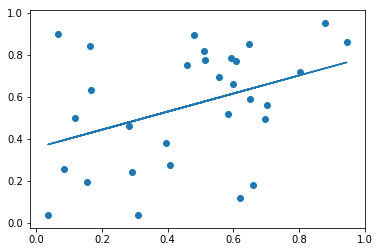

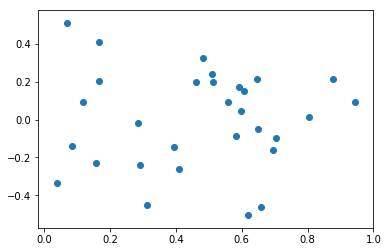

In [16]:
plt.figure(0)
plt.scatter( xcol, y)

fit_values = [ b0 + b1*x for x in xcol]
plt.plot( xcol, fit_values )

residuals = y - fit_values
plt.figure(1)
plt.scatter( xcol, residuals)
